In [1]:
import os
import sys
sys.path.append('/home/royhirsch/conformal/')

import matplotlib.pyplot as plt
import numpy as np
import utils as utils
from experiment import get_config, run_experiment

config = get_config()
utils.seed_everything(config.seed)
utils.create_logger(config.exp_dir, False)
history, val_outputs, train_outputs, val_mets, train_mets = run_experiment(config)

INFO - 08/14/23 07:19:12 - 0:00:00 - Created main log at /home/royhirsch/conformal/exps/temp1/net_launcher_log.log
INFO - 08/14/23 07:19:13 - 0:00:01 - Train/Calib shape: (40000,) | Val shape: (10000,)
INFO - 08/14/23 07:19:19 - 0:00:08 - Baseline mets: set_size_mean: 216.425 | set_size_std: 163.321 | acc_per_label_mean: 0.902 | acc_per_label_max: 1.000 | acc_per_label_min: 0.571 | acc: 0.902 | qhat: 0.868
INFO - 08/14/23 07:19:20 - 0:00:08 - Train/Calib shape: (40000,) | Val shape: (10000,)
INFO - 08/14/23 07:19:21 - 0:00:09 - Clipping 9.85% of the scores to 0.87
INFO - 08/14/23 07:19:21 - 0:00:09 - Clipping 9.91% of the scores to 0.87
INFO - 08/14/23 07:19:26 - 0:00:14 - Train mets after clipping: set_size_mean: 1.963 | set_size_std: 9.200 | acc_per_label_mean: 0.901 | acc_per_label_max: 1.000 | acc_per_label_min: 0.541 | acc: 0.901
INFO - 08/14/23 07:19:27 - 0:00:15 - NN(
                                       (layers): Sequential(
                                         (0): Linea

(0.0, 3.0)

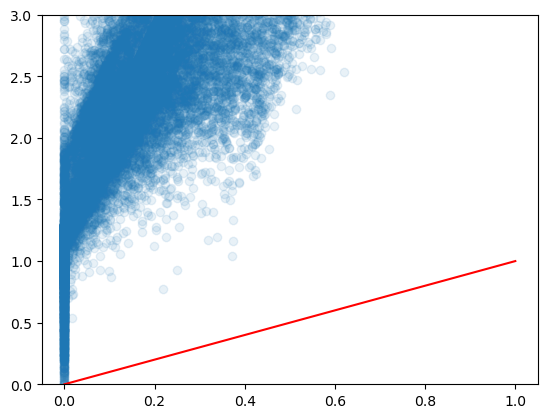

In [16]:
from scipy.stats import entropy
import matplotlib.pyplot as plt

qhat = 0.868
probs = train_outputs['cls_probs']
labels = train_outputs['cls_labels']
scores = train_outputs['true_scores']

res = []
ents = []
for p, l, s in zip(probs, labels, scores):
    ents.append(entropy(p))
    res.append(qhat - s)

ents = np.asarray(ents)
res = np.asarray(res) + 1e-9

plt.scatter(res, ents, alpha = 0.1)
plt.plot([0,1], [0,1], color="red")
plt.ylim([0,3])



In [28]:
import os
import sys
sys.path.append('/home/royhirsch/conformal/')
import numpy as np
from experiment import APS
from data import get_dataloaders
from experiment import get_config, run_experiment

config = get_config()

train_dl, valid_dl, t = get_dataloaders(config, APS())

labels = valid_dl.dataset.cls_labels.numpy()
probs = valid_dl.dataset.cls_probs.numpy()

# get scores
scores = []
for p, l in zip(probs, labels):
    true_class_p = p[l]
    score = np.sum(p[p >= true_class_p])
    scores.append(score)
scores = np.asarray(scores)

conformal_module = APS()

clip_value = np.float32(0.867)
print(np.sum(scores>clip_value))
scores[scores >= clip_value] = clip_value
print(np.sum(scores==clip_value))

sets = []
for s, p, in zip(scores, probs):
    sorted_p = np.sort(p)[::-1]
    argsort_p = np.argsort(p)[::-1]
    cumsum_p = np.cumsum(sorted_p)
    
    ind = np.where(cumsum_p >= s)[0][0]
    if s == clip_value:
        # print('h')
        ind = ind - 1
    sets.append(tuple(argsort_p[:ind + 1]))
APS().get_conformal_mets(sets, labels)


992
992


{'set_size_mean': 2.2877,
 'set_size_std': 12.608922583234463,
 'acc_per_label_mean': 0.9021955499565794,
 'acc_per_label_max': 1.0,
 'acc_per_label_min': 0.16666666666666666,
 'acc': 0.9008}

In [ ]:
train_outputs.keys()
probs = train_outputs['cls_probs']
scores = train_outputs['true_scores']

scores = np.expand_dims(scores, 1)
val_pi = probs.argsort(1)[:, ::-1]
val_srt = np.take_along_axis(probs, val_pi, axis=1).cumsum(axis=1)
prediction_sets = np.take_along_axis(val_srt <= scores, val_pi.argsort(axis=1), axis=1)

sets = []
for i in range(len(prediction_sets)):
    sets.append(tuple(np.where(prediction_sets[i, :] != 0)[0]))

other_sets = []
for s, p, in zip(scores, probs):
    sorted_p = np.sort(p)[::-1]
    argsort_p = np.argsort(p)[::-1]
    cumsum_p = np.cumsum(sorted_p)
    inds = np.where(cumsum_p >= s)[0]
    if len(inds):
        other_sets.append(tuple(argsort_p[:inds[0] + 1]))
    else:
        print('Error')


In [ ]:
import logging
from experiment import APS
from data import get_dataloaders

train_dl, valid_dl, t = get_dataloaders(config, APS())

labels = train_dl.dataset.cls_labels.numpy()
probs = train_dl.dataset.cls_probs.numpy()
scores = train_outputs['true_scores']
n = len(labels)
alpha = 0.1

# get scores
# scores = []
# for p, l in zip(probs, labels):
#     true_class_p = p[l]
#     score = np.sum(p[p >= true_class_p])
#     scores.append(score)
# scores = np.asarray(scores)

# clip
# qhat = np.quantile(
#     scores, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher")
# inds = np.where(scores >= qhat)[0]
# logging.info(f'Clipping {len(inds) / len(scores) * 100.:.2f}% of the scores to {qhat:.2f}')
# scores[inds] = qhat

# score
scores = np.expand_dims(scores,1)
sets = []
for s, p, in zip(scores, probs):
    sorted_p = np.sort(p)[::-1]
    argsort_p = np.argsort(p)[::-1]
    cumsum_p = np.cumsum(sorted_p)
    inds = np.where(cumsum_p >= s)[0]
    if len(inds):
        sets.append(tuple(argsort_p[:inds[0] + 1]))
    else:
        print('Error')
mets = APS().get_conformal_mets(sets, labels)
utils.log('Pred scores', mets)

INFO - 08/13/23 07:04:03 - 0:18:00 - Train/Calib shape: (40000,) | Val shape: (10000,)
INFO - 08/13/23 07:04:10 - 0:18:06 - Pred scores: set_size_mean: 69.605 | set_size_std: 123.262 | acc_per_label_mean: 0.951 | acc_per_label_max: 1.000 | acc_per_label_min: 0.619 | acc: 0.951


# My code

# Anastasiouus code
# true scores
Pred scores: set_size_mean: 2.277 | set_size_std: 13.826 | acc_per_label_mean: 0.882 | acc_per_label_max: 1.000 | acc_per_label_min: 0.564 | acc: 0.882

# pred scores
Pred scores: set_size_mean: 4.389 | set_size_std: 16.558 | acc_per_label_mean: 0.415 | acc_per_label_max: 0.949 | acc_per_label_min: 0.000 | acc: 0.416


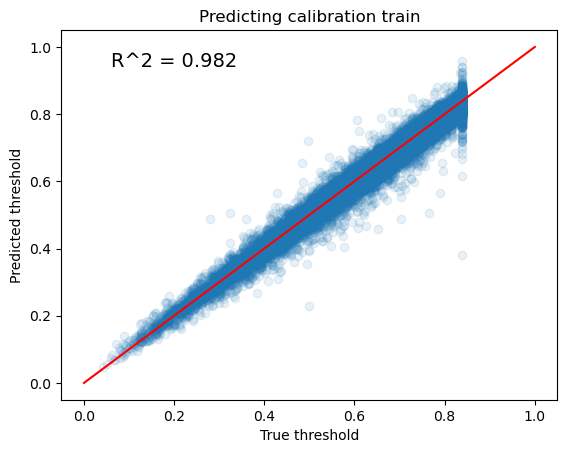

In [ ]:
# outputs = val_outputs
outputs = train_outputs
plt.scatter(outputs['true_scores'], outputs['pred_scores'], alpha = 0.1)
plt.plot([0,1], [0,1], color="red")
plt.xlabel("True threshold")
plt.ylabel("Predicted threshold")

r2 = utils.calc_r2(outputs['true_scores'],outputs['pred_scores'])

plt.text(0.1, 0.9, f"R^2 = {r2:.3f}", transform=plt.gca().transAxes, fontsize=14)
plt.title("Predicting calibration train")
plt.show()

In [ ]:
len(np.where(outputs['pred_scores'] < outputs['true_scores'])[0]) / len(outputs['true_scores'])


0.5797

In [ ]:
true_acc = []
pred_acc = []
s = 0
same = 0
for i, (p, t) in enumerate(zip(outputs['pred_scores'], outputs['true_scores'])):
    l = outputs['cls_labels'][i]
    sorted_probds = np.sort(outputs['cls_probs'][i, :])[::-1]
    cumsum = np.cumsum(sorted_probds)
    inds_sorted_probds = np.argsort(outputs['cls_probs'][i, :])[::-1]

    true_thresh = min(np.where(cumsum >= t)[0]) 
    true_acc.append(l in inds_sorted_probds[:true_thresh])
    pre_thresh = min(np.where(cumsum >= p)[0])
    pred_acc.append(l in inds_sorted_probds[:pre_thresh])
    if pre_thresh < true_thresh:
        s += 1
    elif pre_thresh == true_thresh:
        same += 1
    else: 
        pass

print(s / len(outputs['true_scores']))
print(same / len(outputs['true_scores']))
print('\n\n')
print(np.mean(true_acc))
print(np.mean(pred_acc))
# in 58% of the cases the predicted threshold is lower - the predicted set is smaller

0.03195
0.613775



0.986325
0.9614


In [ ]:
inds_sorted_probds[:true_thresh+1], l

(array([603, 690, 958]), 958)

In [ ]:
np.mean(true_acc)

0.1841875

true: 0.27844518423080444 | pred: 0.4738292694091797 | diff: 0.19538408517837524
0


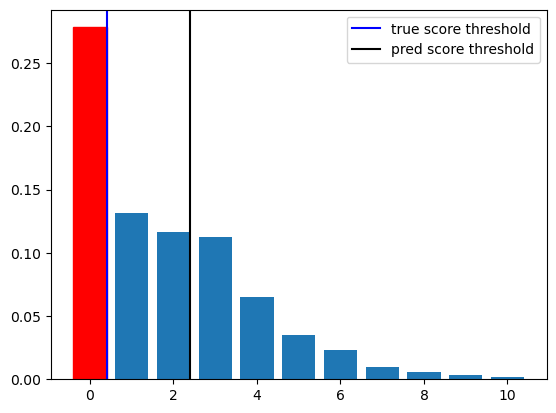

In [ ]:
diff = np.abs(outputs['pred_scores'] - outputs['true_scores'])
inds_sorted_by_max_diff = np.argsort(diff)[::-1]

i = inds_sorted_by_max_diff[6]
true_score = outputs['true_scores'][i]
pred_score = outputs['pred_scores'][i]
print('true: {} | pred: {} | diff: {}'.format(true_score, pred_score, diff[i]))

sorted_probds = np.sort(outputs['cls_probs'][i, :])[::-1]
cumsum = np.cumsum(sorted_probds)
inds_sorted_probds = np.argsort(outputs['cls_probs'][i, :])[::-1]
true_label_prob = outputs['cls_probs'][i, [outputs['cls_labels'][i]]]
ind_true_label_prob = np.where(true_label_prob == outputs['cls_probs'][i, :])[0][0]
ind_true_labe_sorted_probds = np.where(ind_true_label_prob == inds_sorted_probds)[0][0]
print(ind_true_labe_sorted_probds)

m = 11
bars = plt.bar(np.arange(m), sorted_probds[:m])
bars[ind_true_labe_sorted_probds].set_color('r')

plt.axvline(x = min(np.where(cumsum >= true_score)[0]) + 0.4, color = 'b', label = 'true score threshold')
plt.axvline(x = min(np.where(cumsum >= pred_score)[0]) + 0.4, color = 'black', label = 'pred score threshold')
plt.legend()


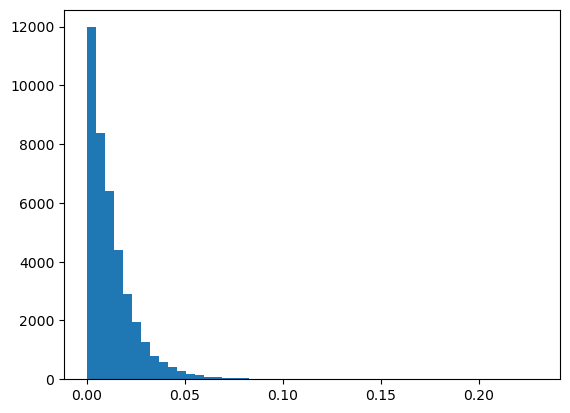

In [ ]:
_=plt.hist(diff, bins=50)

Text(0.5, 1.0, 'Conformal scores dists.')

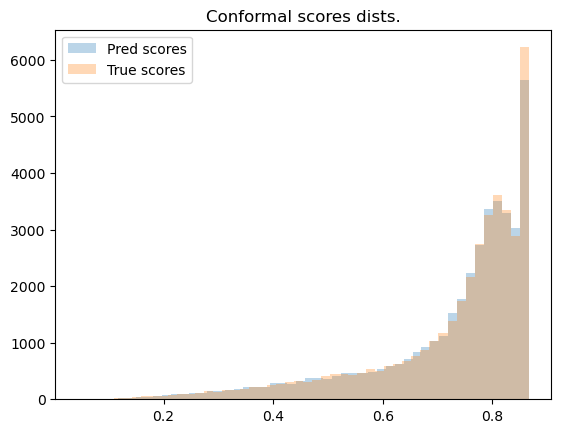

In [ ]:
bins = 50
plt.hist(outputs['pred_scores'], bins, label='Pred scores', alpha=0.3)
plt.hist(outputs['true_scores'], bins, label='True scores', alpha=0.3)
plt.legend()
plt.title('Conformal scores dists.')

Text(0.5, 1.0, 'Train conformal scores')

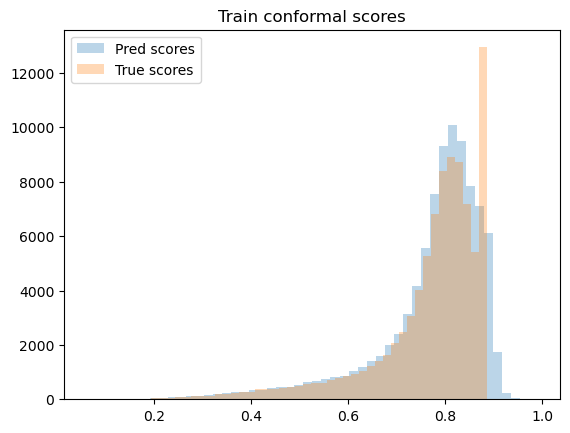

In [ ]:
bins = 50
plt.hist(train_outputs['pred_scores'], bins, label='Pred scores', alpha=0.3)
plt.hist(train_outputs['true_scores'], bins, label='True scores', alpha=0.3)
plt.legend()
plt.title('Train conformal scores')

Text(0.5, 1.0, 'Error (L1) hist')

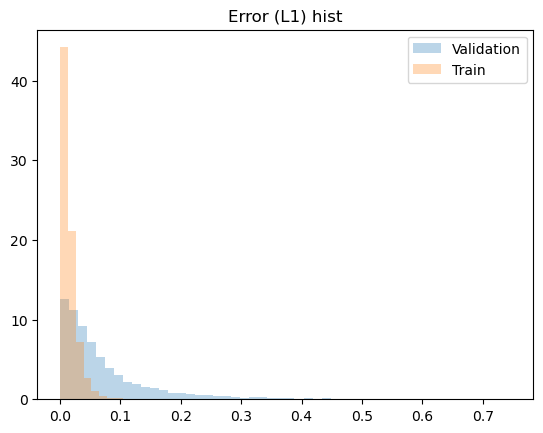

In [ ]:
bins = 50
plt.hist(np.abs(val_outputs['pred_scores'] - val_outputs['true_scores']), bins, label='Validation', alpha=0.3, density=True)
plt.hist(np.abs(train_outputs['pred_scores'] - train_outputs['true_scores']), bins, label='Train', alpha=0.3, density=True)
plt.legend()
plt.title('Error (L1) hist')


In [ ]:
np.arange(0, len(history['loss']), 5)

array([ 0,  5, 10, 15, 20, 25])

Text(0, 0.5, 'MSE Loss')

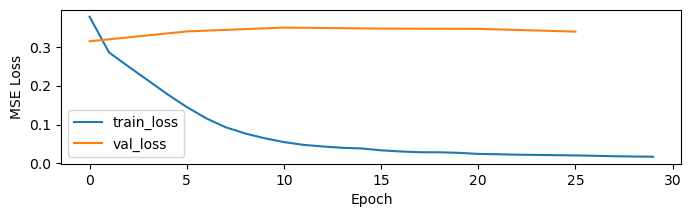

In [ ]:
plt.figure(figsize=(8, 2))
plt.plot(np.arange(len(history['loss'])), history['loss'], label='train_loss')
plt.plot( np.arange(0, len(history['loss']), 5), history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

Text(0, 0.5, 'R^2')

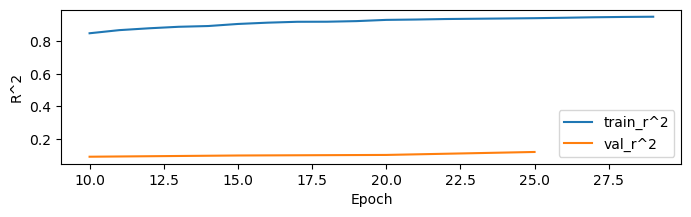

In [ ]:
plt.figure(figsize=(8, 2))
plt.plot(np.arange(len(history['r^2']))[10:], history['r^2'][10:], label='train_r^2')
plt.plot( np.arange(0, len(history['loss']), 5)[2:], history['val_r^2'][2:], label='val_r^2')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('R^2')